# **Week - 3 : Classification**

## **Import Dependencies**

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import kaggle
import requests

import os
import pathlib
import warnings
warnings.filterwarnings('ignore')

### **Download the Dataset**

In [2]:
# Check if the dataset was already downloaded

downloadedFilePath = pathlib.Path.cwd() / "WA_Fn-UseC_-Telco-Customer-Churn.csv"
metadataDir = pathlib.Path.cwd() / "metadata"

if not (downloadedFilePath.is_file() and metadataDir.is_dir()):
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files('blastchar/telco-customer-churn', unzip=True)
    kaggle.api.dataset_metadata('blastchar/telco-customer-churn', path='metadata')
else:
    print(f"Both the metadata directory and the dataset for this module already exist.")

Both the metadata directory and the dataset for this module already exist.


In [3]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


## **Data Preparation**

In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.select_dtypes('object').columns)
for column in categorical_columns:
    df[column] = df[column].str.lower().str.replace(' ', '_')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   seniorcitizen     7043 non-null   int64  
 3   partner           7043 non-null   object 
 4   dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   phoneservice      7043 non-null   object 
 7   multiplelines     7043 non-null   object 
 8   internetservice   7043 non-null   object 
 9   onlinesecurity    7043 non-null   object 
 10  onlinebackup      7043 non-null   object 
 11  deviceprotection  7043 non-null   object 
 12  techsupport       7043 non-null   object 
 13  streamingtv       7043 non-null   object 
 14  streamingmovies   7043 non-null   object 
 15  contract          7043 non-null   object 
 16  paperlessbilling  7043 non-null   object 


In [6]:
tc = pd.to_numeric(df.totalcharges, errors='coerce')
# df[tc.isnull()][['customerid', 'totalcharges']]

df.totalcharges = tc.fillna(0)

In [7]:
df.churn = (df.churn == 'yes').astype(int)

In [8]:
df.churn

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: churn, Length: 7043, dtype: int64

## **Setting up the validation framework**

In [9]:
from sklearn.model_selection import train_test_split

df_fulltrain, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [10]:
len(df_fulltrain), len(df_test)

(5634, 1409)

In [11]:
df_train, df_val = train_test_split(df_fulltrain, test_size=0.25, random_state=1)

In [12]:
len(df_train), len(df_val), len(df_test)

(4225, 1409, 1409)

In [13]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [14]:
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

In [15]:
del df_train['churn']
del df_val['churn']
del df_test['churn']

## **Eploratory Data Analysis**

In [16]:
df_fulltrain = df_fulltrain.reset_index(drop=True)

In [17]:
df_fulltrain.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0
1,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,...,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1
2,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,...,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0
3,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,...,yes,yes,yes,yes,one_year,no,electronic_check,85.45,6300.85,0
4,2364-ufrom,male,0,no,no,30,yes,no,dsl,yes,...,no,yes,yes,no,one_year,no,electronic_check,70.40,2044.75,0


In [18]:
df_fulltrain.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [19]:
df_fulltrain.churn.value_counts(normalize=True)

churn
0    0.730032
1    0.269968
Name: proportion, dtype: float64

In [20]:
global_churn_rate = df_fulltrain.churn.mean()
np.round(global_churn_rate, 2)

np.float64(0.27)

In [21]:
df_fulltrain.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges        float64
churn                 int64
dtype: object

In [22]:
id = ['customerid']

In [23]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [24]:
mask = np.isin(df_fulltrain.columns, numerical + id)
categorical = df_fulltrain.columns[~mask].drop('churn')
categorical

Index(['gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice',
       'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup',
       'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies',
       'contract', 'paperlessbilling', 'paymentmethod'],
      dtype='object')

In [25]:
df_fulltrain[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

## **Feature Importance: Churn Rate and Risk Ratio**

In [26]:
df_fulltrain.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0
1,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,...,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1
2,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,...,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0
3,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,...,yes,yes,yes,yes,one_year,no,electronic_check,85.45,6300.85,0
4,2364-ufrom,male,0,no,no,30,yes,no,dsl,yes,...,no,yes,yes,no,one_year,no,electronic_check,70.40,2044.75,0


In [27]:
churn_female = df_fulltrain[df_fulltrain.gender == 'female'].churn.mean()
churn_female

np.float64(0.27682403433476394)

In [28]:
global_churn_rate - churn_female

np.float64(-0.006855983216553063)

In [29]:
churn_male = df_fulltrain[df_fulltrain.gender == 'male'].churn.mean()
churn_male

np.float64(0.2632135306553911)

In [30]:
global_churn_rate - churn_male

np.float64(0.006754520462819769)

In [31]:
churn_partner = df_fulltrain[df_fulltrain.partner == 'yes'].churn.mean()
churn_partner

np.float64(0.20503330866025166)

In [32]:
global_churn_rate - churn_partner

np.float64(0.06493474245795922)

In [33]:
churn_no_partner = df_fulltrain[df_fulltrain.partner == 'no'].churn.mean()
churn_no_partner

np.float64(0.3298090040927694)

In [34]:
global_churn_rate - churn_no_partner

np.float64(-0.05984095297455855)

### Risk Ratio

In [35]:
churn_no_partner / global_churn_rate

np.float64(1.2216593879412643)

In [36]:
churn_partner / global_churn_rate

np.float64(0.7594724924338315)

In [37]:
from IPython.display import display

for category in categorical:
    print(category)
    df_group = df_fulltrain.groupby(category).churn.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_churn_rate
    df_group['risk'] = df_group['mean'] / global_churn_rate
    display(df_group)
    print("\n" * 2)

gender


,mean,count,diff,risk
gender,,,,
female,0.276824,2796,0.006856,1.025396
male,0.263214,2838,-0.006755,0.974980





seniorcitizen


,mean,count,diff,risk
seniorcitizen,,,,
0,0.242270,4722,-0.027698,0.897403
1,0.413377,912,0.143409,1.531208





partner


,mean,count,diff,risk
partner,,,,
no,0.329809,2932,0.059841,1.221659
yes,0.205033,2702,-0.064935,0.759472





dependents


,mean,count,diff,risk
dependents,,,,
no,0.313760,3968,0.043792,1.162212
yes,0.165666,1666,-0.104302,0.613651





phoneservice


,mean,count,diff,risk
phoneservice,,,,
no,0.241316,547,-0.028652,0.893870
yes,0.273049,5087,0.003081,1.011412





multiplelines


,mean,count,diff,risk
multiplelines,,,,
no,0.257407,2700,-0.012561,0.953474
no_phone_service,0.241316,547,-0.028652,0.893870
yes,0.290742,2387,0.020773,1.076948





internetservice


,mean,count,diff,risk
internetservice,,,,
dsl,0.192347,1934,-0.077621,0.712482
fiber_optic,0.425171,2479,0.155203,1.574895
no,0.077805,1221,-0.192163,0.288201





onlinesecurity


,mean,count,diff,risk
onlinesecurity,,,,
no,0.420921,2801,0.150953,1.559152
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.153226,1612,-0.116742,0.567570





onlinebackup


,mean,count,diff,risk
onlinebackup,,,,
no,0.404323,2498,0.134355,1.497672
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.217232,1915,-0.052736,0.804660





deviceprotection


,mean,count,diff,risk
deviceprotection,,,,
no,0.395875,2473,0.125907,1.466379
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.230412,1940,-0.039556,0.853480





techsupport


,mean,count,diff,risk
techsupport,,,,
no,0.418914,2781,0.148946,1.551717
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.159926,1632,-0.110042,0.592390





streamingtv


,mean,count,diff,risk
streamingtv,,,,
no,0.342832,2246,0.072864,1.269897
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.302723,2167,0.032755,1.121328





streamingmovies


,mean,count,diff,risk
streamingmovies,,,,
no,0.338906,2213,0.068938,1.255358
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.307273,2200,0.037305,1.138182





contract


,mean,count,diff,risk
contract,,,,
month-to-month,0.431701,3104,0.161733,1.599082
one_year,0.120573,1186,-0.149395,0.446621
two_year,0.028274,1344,-0.241694,0.104730





paperlessbilling


,mean,count,diff,risk
paperlessbilling,,,,
no,0.172071,2313,-0.097897,0.637375
yes,0.338151,3321,0.068183,1.252560





paymentmethod


,mean,count,diff,risk
paymentmethod,,,,
bank_transfer_(automatic),0.168171,1219,-0.101797,0.622928
credit_card_(automatic),0.164339,1217,-0.105630,0.608733
electronic_check,0.455890,1893,0.185922,1.688682
mailed_check,0.193870,1305,-0.076098,0.718121


## **Feature Importance: Mutual Information**

In [38]:
from sklearn.metrics import mutual_info_score

In [39]:
mutual_info_score(df_fulltrain.churn, df_fulltrain.contract)

0.0983203874041556

In [40]:
mutual_info_score(df_fulltrain.churn, df_fulltrain.gender)

0.0001174846211139946

In [41]:
mutual_info_score(df_fulltrain.churn, df_fulltrain.partner)

0.009967689095399745

In [42]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, df_fulltrain.churn)

In [43]:
mi = df_fulltrain[categorical].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

contract            0.098320
onlinesecurity      0.063085
techsupport         0.061032
internetservice     0.055868
onlinebackup        0.046923
deviceprotection    0.043453
paymentmethod       0.043210
streamingtv         0.031853
streamingmovies     0.031581
paperlessbilling    0.017589
dependents          0.012346
partner             0.009968
seniorcitizen       0.009410
multiplelines       0.000857
phoneservice        0.000229
gender              0.000117
dtype: float64

## **Feature Importance: Correlation**

In [44]:
df_fulltrain.tenure.max()

np.int64(72)

In [45]:
df_fulltrain[numerical].totalcharges.unique()

array([ 258.35, 3160.55, 4681.75, ..., 2979.5 ,  114.1 , 1114.85],
      shape=(5291,))

In [46]:
df_fulltrain[numerical].corrwith(df_fulltrain.churn)

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.196353
dtype: float64

In [47]:
df_fulltrain[df_fulltrain.tenure <= 2].churn.mean()

np.float64(0.5953420669577875)

In [48]:
df_fulltrain[(df_fulltrain.tenure > 2) & (df_fulltrain.tenure <= 12)].churn.mean()

np.float64(0.3994413407821229)

In [49]:
df_fulltrain[df_fulltrain.tenure > 12].churn.mean()

np.float64(0.17634908339788277)

Tenure shows a negative correlation with the churn rate

In [50]:
df_fulltrain[df_fulltrain.monthlycharges <= 20].churn.mean()

np.float64(0.08795411089866156)

In [51]:
df_fulltrain[(df_fulltrain.monthlycharges > 20) & (df_fulltrain.monthlycharges <= 50)].churn.mean()

np.float64(0.18340943683409436)

In [52]:
df_fulltrain[df_fulltrain.monthlycharges > 50].churn.mean()

np.float64(0.32499341585462205)

While monthlycharges shows a negative correlation with the churn rate

## **One-Hot Encoding**

In [53]:
from sklearn.feature_extraction import DictVectorizer

In [54]:
df_train[['gender', 'contract', 'tenure']].iloc[: 100]

,gender,contract,tenure
0,female,two_year,72
1,male,month-to-month,10
2,female,month-to-month,5
3,female,month-to-month,5
4,female,two_year,18
...,...,...,...
95,male,one_year,39
96,female,month-to-month,19
97,male,month-to-month,21
98,male,one_year,43


In [55]:
train_dicts = df_train[list(categorical) + numerical].to_dict(orient='records')

In [56]:
train_dicts

[{'gender': 'female',
  'seniorcitizen': 0,
  'partner': 'yes',
  'dependents': 'yes',
  'phoneservice': 'yes',
  'multiplelines': 'yes',
  'internetservice': 'fiber_optic',
  'onlinesecurity': 'yes',
  'onlinebackup': 'yes',
  'deviceprotection': 'yes',
  'techsupport': 'yes',
  'streamingtv': 'yes',
  'streamingmovies': 'yes',
  'contract': 'two_year',
  'paperlessbilling': 'yes',
  'paymentmethod': 'electronic_check',
  'tenure': 72,
  'monthlycharges': 115.5,
  'totalcharges': 8425.15},
 {'gender': 'male',
  'seniorcitizen': 0,
  'partner': 'no',
  'dependents': 'no',
  'phoneservice': 'yes',
  'multiplelines': 'yes',
  'internetservice': 'fiber_optic',
  'onlinesecurity': 'no',
  'onlinebackup': 'yes',
  'deviceprotection': 'yes',
  'techsupport': 'no',
  'streamingtv': 'no',
  'streamingmovies': 'yes',
  'contract': 'month-to-month',
  'paperlessbilling': 'yes',
  'paymentmethod': 'electronic_check',
  'tenure': 10,
  'monthlycharges': 95.25,
  'totalcharges': 1021.55},
 {'gender

In [57]:
dv = DictVectorizer(sparse=False)

In [58]:
dv.fit(train_dicts)

,dtype,<class 'numpy.float64'>
,separator,'='
,sparse,False
,sort,True


In [59]:
dv.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'dependents=no', 'dependents=yes',
       'deviceprotection=no', 'deviceprotection=no_internet_service',
       'deviceprotection=yes', 'gender=female', 'gender=male',
       'internetservice=dsl', 'internetservice=fiber_optic',
       'internetservice=no', 'monthlycharges', 'multiplelines=no',
       'multiplelines=no_phone_service', 'multiplelines=yes',
       'onlinebackup=no', 'onlinebackup=no_internet_service',
       'onlinebackup=yes', 'onlinesecurity=no',
       'onlinesecurity=no_internet_service', 'onlinesecurity=yes',
       'paperlessbilling=no', 'paperlessbilling=yes', 'partner=no',
       'partner=yes', 'paymentmethod=bank_transfer_(automatic)',
       'paymentmethod=credit_card_(automatic)',
       'paymentmethod=electronic_check', 'paymentmethod=mailed_check',
       'phoneservice=no', 'phoneservice=yes', 'seniorcitizen',
       'streamingmovies=no', 'streamingmovies=no_internet_service',

In [60]:
dv.transform(train_dicts[:10])

array([[0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 1.15500e+02, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 7.20000e+01, 8.42515e+03],
       [1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 9.52500e+01, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.0

In [61]:
X_train = dv.fit_transform(train_dicts)

In [62]:
val_dicts = df_val[list(categorical) + numerical].to_dict(orient='records')

In [63]:
X_val = dv.transform(val_dicts)

## **Logistic Regression**

In [64]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [65]:
z = np.linspace(-7, 7, 51)

In [66]:
sigmoid(z)

array([9.11051194e-04, 1.20508423e-03, 1.59386223e-03, 2.10780106e-03,
       2.78699622e-03, 3.68423990e-03, 4.86893124e-03, 6.43210847e-03,
       8.49286285e-03, 1.12064063e-02, 1.47740317e-02, 1.94550846e-02,
       2.55807883e-02, 3.35692233e-02, 4.39398154e-02, 5.73241759e-02,
       7.44679452e-02, 9.62155417e-02, 1.23467048e-01, 1.57095469e-01,
       1.97816111e-01, 2.46011284e-01, 3.01534784e-01, 3.63547460e-01,
       4.30453776e-01, 5.00000000e-01, 5.69546224e-01, 6.36452540e-01,
       6.98465216e-01, 7.53988716e-01, 8.02183889e-01, 8.42904531e-01,
       8.76532952e-01, 9.03784458e-01, 9.25532055e-01, 9.42675824e-01,
       9.56060185e-01, 9.66430777e-01, 9.74419212e-01, 9.80544915e-01,
       9.85225968e-01, 9.88793594e-01, 9.91507137e-01, 9.93567892e-01,
       9.95131069e-01, 9.96315760e-01, 9.97213004e-01, 9.97892199e-01,
       9.98406138e-01, 9.98794916e-01, 9.99088949e-01])

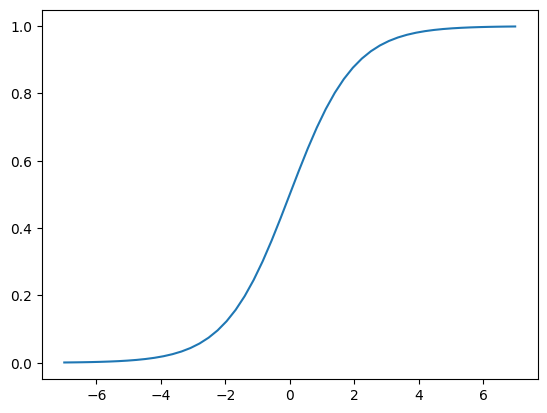

In [67]:
plt.plot(z, sigmoid(z))

In [68]:
def linearRegression(xi):
    result = w0

    for j in range(len(w)):
        result = result + xi[j] * w[j]

    return result

In [69]:
def logisticRegression(xi):
    score = w0

    for j in range(len(w)):
        score = score + xi[j] * w[j]

    result = sigmoid(score)
    return result

## **Training Logistic Regression with Scikit-Learn**

In [70]:
from sklearn.linear_model import LogisticRegression

In [71]:
model = LogisticRegression()
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [72]:
model.intercept_[0]

np.float64(-0.10893688488157861)

In [73]:
model.coef_[0].round(3)

array([ 0.473, -0.175, -0.406, -0.029, -0.078,  0.063, -0.089, -0.081,
       -0.034, -0.073, -0.335,  0.316, -0.089,  0.004, -0.258,  0.141,
        0.009,  0.063, -0.089, -0.081,  0.265, -0.089, -0.284, -0.231,
        0.124, -0.166,  0.058, -0.087, -0.032,  0.071, -0.059,  0.141,
       -0.248,  0.215, -0.12 , -0.089,  0.101, -0.071, -0.089,  0.052,
        0.213, -0.089, -0.232, -0.07 ,  0.   ])

In [74]:
model.predict(X_val)

array([0, 0, 0, ..., 0, 1, 1], shape=(1409,))

In [75]:
model.predict_proba(X_val)

array([[0.99097817, 0.00902183],
       [0.79547161, 0.20452839],
       [0.78767705, 0.21232295],
       ...,
       [0.863388  , 0.136612  ],
       [0.20025998, 0.79974002],
       [0.16268997, 0.83731003]], shape=(1409, 2))

In [76]:
y_pred = model.predict_proba(X_val)[:, 1]
y_pred

array([0.00902183, 0.20452839, 0.21232295, ..., 0.136612  , 0.79974002,
       0.83731003], shape=(1409,))

In [77]:
churn_decision = (y_pred >= 0.5)

In [78]:
df_val[churn_decision].customerid

3       8433-wxgna
8       3440-jpscl
11      2637-fkfsy
12      7228-omtpn
19      6711-fldfb
           ...    
1397    5976-jcjrh
1398    2034-cgrhz
1399    5276-kqwhg
1407    6521-yytyi
1408    3049-solay
Name: customerid, Length: 312, dtype: object

In [79]:
(y_val == churn_decision).mean()

np.float64(0.8026969481902059)

In [80]:
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['prediction'] = churn_decision.astype(int)
df_pred['actual'] = y_val

In [81]:
df_pred['correct'] = df_pred.prediction == df_pred.actual

In [82]:
df_pred.correct.mean()

np.float64(0.8026969481902059)

In [83]:
churn_decision.astype(int)

array([0, 0, 0, ..., 0, 1, 1], shape=(1409,))

## **Model Interpretation**

In [84]:
a = [1, 2, 3, 4]
b = 'abcd'

In [85]:
dict(zip(a, b))

{1: 'a', 2: 'b', 3: 'c', 4: 'd'}

In [86]:
dict(zip(dv.get_feature_names_out(), model.coef_[0].round(3)))

{'contract=month-to-month': np.float64(0.473),
 'contract=one_year': np.float64(-0.175),
 'contract=two_year': np.float64(-0.406),
 'dependents=no': np.float64(-0.029),
 'dependents=yes': np.float64(-0.078),
 'deviceprotection=no': np.float64(0.063),
 'deviceprotection=no_internet_service': np.float64(-0.089),
 'deviceprotection=yes': np.float64(-0.081),
 'gender=female': np.float64(-0.034),
 'gender=male': np.float64(-0.073),
 'internetservice=dsl': np.float64(-0.335),
 'internetservice=fiber_optic': np.float64(0.316),
 'internetservice=no': np.float64(-0.089),
 'monthlycharges': np.float64(0.004),
 'multiplelines=no': np.float64(-0.258),
 'multiplelines=no_phone_service': np.float64(0.141),
 'multiplelines=yes': np.float64(0.009),
 'onlinebackup=no': np.float64(0.063),
 'onlinebackup=no_internet_service': np.float64(-0.089),
 'onlinebackup=yes': np.float64(-0.081),
 'onlinesecurity=no': np.float64(0.265),
 'onlinesecurity=no_internet_service': np.float64(-0.089),
 'onlinesecurity=yes

In [87]:
small = ['contract', 'tenure', 'monthlycharges']

In [88]:
df_train[small].iloc[:10].to_dict(orient='records')

[{'contract': 'two_year', 'tenure': 72, 'monthlycharges': 115.5},
 {'contract': 'month-to-month', 'tenure': 10, 'monthlycharges': 95.25},
 {'contract': 'month-to-month', 'tenure': 5, 'monthlycharges': 75.55},
 {'contract': 'month-to-month', 'tenure': 5, 'monthlycharges': 80.85},
 {'contract': 'two_year', 'tenure': 18, 'monthlycharges': 20.1},
 {'contract': 'month-to-month', 'tenure': 4, 'monthlycharges': 30.5},
 {'contract': 'month-to-month', 'tenure': 1, 'monthlycharges': 75.1},
 {'contract': 'month-to-month', 'tenure': 1, 'monthlycharges': 70.3},
 {'contract': 'two_year', 'tenure': 72, 'monthlycharges': 19.75},
 {'contract': 'month-to-month', 'tenure': 6, 'monthlycharges': 109.9}]

In [89]:
dicts_train_small = df_train[small].to_dict(orient='records')
dicts_val_small = df_val[small].to_dict(orient='records')

In [90]:
dv_small = DictVectorizer(sparse=False)
dv_small.fit(dicts_train_small)

,dtype,<class 'numpy.float64'>
,separator,'='
,sparse,False
,sort,True


In [91]:
dv_small.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'monthlycharges', 'tenure'], dtype=object)

In [92]:
X_train_small = dv_small.transform(dicts_train_small)

In [93]:
model_small = LogisticRegression()
model_small.fit(X_train_small, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [94]:
w0 = model_small.intercept_[0]
w0

np.float64(-2.477957595406315)

In [95]:
w = model_small.coef_[0]
w.round(3)

array([ 0.971, -0.024, -0.948,  0.027, -0.036])

In [96]:
dict(zip(dv_small.get_feature_names_out(), model_small.coef_[0].round(3)))

{'contract=month-to-month': np.float64(0.971),
 'contract=one_year': np.float64(-0.024),
 'contract=two_year': np.float64(-0.948),
 'monthlycharges': np.float64(0.027),
 'tenure': np.float64(-0.036)}

The small model interpretation

$$ \begin {align}
dv_{small} & = w_0 + w_{contract}s + w_{monthlycharges} + w_{tenure} \\
& = -2.47 + (0.97, -0.024, -0.948) + (0.027) + (-0.036)
\end {align}
$$

The negative values show a negative correlation with that variable and churn rate, for example, if the contract is one year then the user is less likely to churn but two year the probability of churning become significantly less. 

In [97]:
-2.47 + 0.97 + (50 * 0.027) + (5 * -0.036)

-0.3300000000000001

In [98]:
sigmoid(_) # The probability of churning is approximately 42 percent

np.float64(0.41824062315816374)

## **Using the Model**

In [102]:
dicts_full_train = df_fulltrain[list(categorical) + numerical].to_dict(orient='records')

In [103]:
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

In [104]:
y_full_train = df_fulltrain.churn.values

In [106]:
model = LogisticRegression()
model.fit(X_full_train, y_full_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [109]:
dicts_test = df_test[list(categorical) + numerical].to_dict(orient='records')

In [110]:
X_test = dv.transform(dicts_test)

In [111]:
y_pred = model.predict_proba(X_test)[:, 1]

In [112]:
churn_decision = (y_pred >= 0.5)

In [113]:
(churn_decision == y_test).mean()

np.float64(0.8076650106458482)

In [119]:
customer = dicts_test[-1]
customer

{'gender': 'female',
 'seniorcitizen': 0,
 'partner': 'yes',
 'dependents': 'yes',
 'phoneservice': 'yes',
 'multiplelines': 'yes',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'yes',
 'onlinebackup': 'no',
 'deviceprotection': 'yes',
 'techsupport': 'no',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'month-to-month',
 'paperlessbilling': 'yes',
 'paymentmethod': 'electronic_check',
 'tenure': 17,
 'monthlycharges': 104.2,
 'totalcharges': 1743.5}

In [120]:
X_small = dv.transform([customer])

In [121]:
model.predict_proba(X_small)[0, 1]

np.float64(0.6239875684169238)

In [122]:
y_test[-1]

np.int64(1)